## Convert the graph into natural langauge sentences

This is a very simple way to "serialize" a knowledge graph

In [1]:
from glob import glob
import rdflib
from tqdm import tqdm

# Define the namespace prefix (adjust if needed)
CO_LEARNING_NS = "http://example.org/co_learning#"


# Helper function to extract literals and form a sentence
def extract_literals_to_sentence(g, node):
    sentence_parts = []

    # Extract the literal values for the relevant properties
    for _, p, o in g.triples((node, None, None)):
        if (
            p.endswith("hasActor")
            or p.endswith("hasAction")
            or p.endswith("hasLocation")
            or p.endswith("hasObject")
        ):
            sentence_parts.append(str(o))  # Add the literal to the sentence parts

    # Join the sentence parts with a space
    return " ".join(sentence_parts)


# Function to convert a graph into three sentences
def graph_to_sentences(ttl_file: str):
    # Load the RDF graph
    g = rdflib.Graph()
    g.parse(ttl_file, format="turtle")

    situation_sentence = []
    action_human_sentence = []
    action_robot_sentence = []

    # Find instances of Situation, ActionHuman, and ActionRobot and generate sentences
    for s, rdf_type in g.subject_objects(rdflib.RDF.type):
        rdf_type_str = str(rdf_type)

        if rdf_type_str == CO_LEARNING_NS + "Situation":
            extracted = extract_literals_to_sentence(g, s)
            if extracted:
                situation_sentence.append(extracted)
        elif rdf_type_str == CO_LEARNING_NS + "ActionHuman":
            extracted = extract_literals_to_sentence(g, s)
            if extracted:
                action_human_sentence.append(extracted)
        elif rdf_type_str == CO_LEARNING_NS + "ActionRobot":
            extracted = extract_literals_to_sentence(g, s)
            if extracted:
                action_robot_sentence.append(extracted)

    situation_sentence = ", ".join(situation_sentence)
    action_human_sentence = ", ".join(action_human_sentence)
    action_robot_sentence = ", ".join(action_robot_sentence)

    return situation_sentence, action_human_sentence, action_robot_sentence


words = []

# Loop through all .ttl files and convert each to three sentences
for ttl_path in tqdm(sorted(glob("./rdf-data/*.ttl"))):
    situation, action_human, action_robot = graph_to_sentences(ttl_path)

    words.append(
        {
            "situation": situation,
            "action_human": action_human,
            "action_robot": action_robot,
        }
    )

    # Print or save the result (example prints for now)
    print(f"Graph: {ttl_path}")
    print(f"Situation: {situation}")
    print(f"ActionHuman: {action_human}")
    print(f"ActionRobot: {action_robot}")
    print("---\n")

  0%|          | 0/211 [00:00<?, ?it/s]

 39%|███▉      | 82/211 [00:00<00:00, 811.06it/s]

Graph: ./rdf-data/000.ttl
Situation: 
ActionHuman: Stand still in <location> Human <Left> side of field
ActionRobot: Break <object> in <location> Brown rock
---

Graph: ./rdf-data/001.ttl
Situation: Top of rock pile Large rock, <Left> side of rock pile Large rock, Human <Right> side of field
ActionHuman: Stand still in <location> <Right> side of field
ActionRobot: Break <object> in <location> Top of rock pile Large rock
---

Graph: ./rdf-data/002.ttl
Situation: Bottom of rock pile Large rock
ActionHuman: Move back and forth in <location> Bottom of rock pile
ActionRobot: Break <object> in <location> Bottom of rock pile Large rock
---

Graph: ./rdf-data/003.ttl
Situation: Top of rock pile Large rock, Human <Right> side of field
ActionHuman: Stand still in <location> <Right> side of field
ActionRobot: Break <object> in <location> Top of rock pile Large rock
---

Graph: ./rdf-data/004.ttl
Situation: Top of rock pile Large rock, Human <Right> side of field
ActionHuman: Move back and forth i

100%|██████████| 211/211 [00:00<00:00, 746.46it/s]

Graph: ./rdf-data/152.ttl
Situation: Top of rock pile Large rock
ActionHuman: 
ActionRobot: Pick up <object> in <location> Top of rock pile Large rock
---

Graph: ./rdf-data/153.ttl
Situation: Top of rock pile Small rock
ActionHuman: Pick up <object> in <location> Top of rock pile Small rock
ActionRobot: Pick up <object> in <location> Top of rock pile Small rock, Drop <object> in <location> <Left> side of field Small rock
---

Graph: ./rdf-data/154.ttl
Situation: Bottom of rock pile Small rock
ActionHuman: Pick up <object> in <location> Bottom of rock pile Small rock
ActionRobot: Pick up <object> in <location> Victim On top of <Actor> Small rock
---

Graph: ./rdf-data/155.ttl
Situation: Bottom of rock pile Small rock
ActionHuman: Pick up <object> in <location> Bottom of rock pile Small rock
ActionRobot: Pick up <object> in <location> Victim On top of <Actor> Small rock
---

Graph: ./rdf-data/156.ttl
Situation: Top of rock pile Small rock
ActionHuman: Pick up <object> in <location> Top 

## Make bag-of-words feature vectors.

I do this cuz I know that the vocabulary size is quite small

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Combine the extracted sentences into a single string for each collaboration pattern
corpus = [
    f"{w['situation']}. {w['action_human']}. {w['action_robot']}."
    for w in words
]

# Use CountVectorizer to create the bag-of-words feature matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Convert the feature matrix into a DataFrame for easy visualization
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_bow

,above,actor,and,back,bottom,break,brown,drop,field,forth,...,robot,rock,side,small,stand,still,to,top,up,victim
0,0,0,0,0,0,1,1,0,1,0,...,0,1,1,0,1,1,0,0,0,0
1,0,0,0,0,0,1,0,0,2,0,...,0,6,3,0,1,1,0,2,0,0
2,0,0,1,1,3,1,0,0,0,1,...,0,5,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,2,0,...,0,4,2,0,1,1,0,2,0,0
4,0,0,1,1,0,1,0,0,2,1,...,0,4,2,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,2,1,0
207,0,0,0,0,0,0,0,0,0,0,...,0,4,0,2,0,0,0,2,1,0
208,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,2,1,0
209,0,0,0,0,0,0,0,0,0,0,...,0,4,0,2,0,0,0,2,1,0


## Clustering with K-means

Play around with the number of clusters

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform K-Means clustering (adjust n_clusters based on your data)
n_clusters = 3  # You can experiment with different numbers of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X)

# Get the cluster labels for each collaboration pattern
labels = kmeans.labels_

# Calculate the silhouette score to evaluate the clustering
silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score for KMeans with {n_clusters} clusters: {silhouette_avg:.4f}")

# Add the cluster labels to the DataFrame for inspection
df_bow['Cluster'] = labels
df_bow

/home/tk/.virtualenvs/co-learning/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score for KMeans with 3 clusters: 0.2191


,above,actor,and,back,bottom,break,brown,drop,field,forth,...,rock,side,small,stand,still,to,top,up,victim,Cluster
0,0,0,0,0,0,1,1,0,1,0,...,1,1,0,1,1,0,0,0,0,1
1,0,0,0,0,0,1,0,0,2,0,...,6,3,0,1,1,0,2,0,0,0
2,0,0,1,1,3,1,0,0,0,1,...,5,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,2,0,...,4,2,0,1,1,0,2,0,0,0
4,0,0,1,1,0,1,0,0,2,1,...,4,2,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,2,1,0,1
207,0,0,0,0,0,0,0,0,0,0,...,4,0,2,0,0,0,2,1,0,1
208,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,2,1,0,1
209,0,0,0,0,0,0,0,0,0,0,...,4,0,2,0,0,0,2,1,0,1


## Visualize the clusters and points using PCA

t-SNE might be better

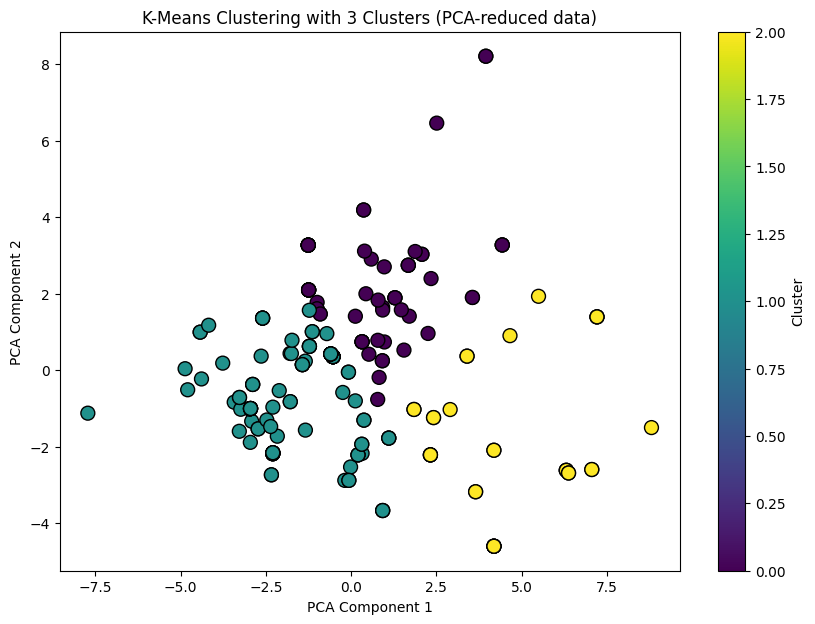

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce the dimensionality of the data using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=100)
plt.title(f"K-Means Clustering with {n_clusters} Clusters (PCA-reduced data)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [5]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances_argmin_min

# Step 3: Get the cluster centroids
centroids = kmeans.cluster_centers_

# Step 4: Find the row/point closest to the centroid for each cluster
closest, _ = pairwise_distances_argmin_min(centroids, X)

for i, index in enumerate(closest):
    print(
        f"Cluster {i}: Closest vector to centroid is at index {index}, which corresponds to: '{corpus[index]}'"
    )

Cluster 0: Closest vector to centroid is at index 23, which corresponds to: 'Top of rock pile Large rock. Stand still in <location> <Left> side of field. Pick up <object> in <location> Top of rock pile Large rock, Drop <object> in <location> <Right> side of field Large rock.'
Cluster 1: Closest vector to centroid is at index 150, which corresponds to: 'Top of rock pile Large rock. . Pick up <object> in <location> Top of rock pile Large rock.'
Cluster 2: Closest vector to centroid is at index 151, which corresponds to: 'Top of rock pile Small rock. Pick up <object> in <location> Top of rock pile Small rock. Pick up <object> in <location> Top of rock pile Small rock, Drop <object> in <location> <Left> side of field Small rock.'


In [6]:
closest

array([ 23, 150, 151])